<a href="https://colab.research.google.com/github/jcheng93/Blockchain-Capstone-Project/blob/main/Coinmetrics_Data_Project_Preprocessing_and_Model_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# Define the file paths in your Google Drive
eth_csv_path = '/content/drive/My Drive/Colab Notebooks/Coinmetrics Data/eth_clean_df.csv'
btc_csv_path = '/content/drive/My Drive/Colab Notebooks/Coinmetrics Data/btc_clean_df.csv'

# Load CSV files into DataFrames
eth_df = pd.read_csv(eth_csv_path, index_col = 'index')
btc_df = pd.read_csv(btc_csv_path, index_col = 'index')

Mounted at /content/drive


In [ ]:
#print(eth_df.info())
print(btc_df.info())

eth_df.index = pd.to_datetime(eth_df.index)
btc_df.index = pd.to_datetime(btc_df.index)


<class 'pandas.core.frame.DataFrame'>
Index: 2382 entries, 2017-04-03 to 2023-10-10
Data columns (total 60 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   AdrActCnt                                   2382 non-null   int64  
 1   AdrBalNtv0.1Cnt                             2382 non-null   int64  
 2   CapMVRVCur                                  2382 non-null   float64
 3   DiffLast                                    2382 non-null   float64
 4   FeeTotNtv                                   2382 non-null   float64
 5   FlowInExNtv                                 2382 non-null   float64
 6   FlowOutExNtv                                2382 non-null   float64
 7   HashRate                                    2382 non-null   float64
 8   ReferenceRateUSD                            2382 non-null   float64
 9   SplyFF                                      2382 non-null   float64
 10  Sp

In [ ]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(actual, predicted):

    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return rmse

#print(f'RMSE for SMA Predictions: {rmse_sma}')


In [ ]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(time_series, lags=40):
    """
    Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for a time series.

    Parameters:
    - time_series: Series or array-like, the time series
    - lags: int, number of lags to include in the plots

    Returns:
    - None (plots the ACF and PACF)
    """
    # Plot ACF
    plt.figure(figsize=(12, 6))
    plot_acf(time_series, lags=lags, alpha=0.05)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()

    # Plot PACF
    plt.figure(figsize=(12, 6))
    plot_pacf(time_series, lags=lags, alpha=0.05)
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.show()





In [ ]:
def calculate_mean_stdev(series):
    """
    Calculate the mean and standard deviation of a series.

    Parameters:
    - series: pandas Series, the input series

    Returns:
    - mean: float, the mean of the series
    - stdev: float, the standard deviation of the series
    """
    mean = series.mean()
    stdev = series.std()
    return mean, stdev

# Example usage:
mean, stdev = calculate_mean_stdev(btc_df['price_pct_change'])
print(f"Mean of price_pct_change: {mean}")
print(f"Standard Deviation of price_pct_change: {stdev}")


Mean of price_pct_change: 0.21282318629816738
Standard Deviation of price_pct_change: 3.912141934373631


In [ ]:
def train_test_split_time_series(data, train_size):
    """
    Split a time series into training and testing sets.

    Parameters:
    - data: DataFrame, the input data (with a datetime index)
    - train_size: float, the proportion of the data to include in the training set

    Returns:
    - train_data: DataFrame, the training set
    - test_data: DataFrame, the testing set
    """
    data = data.sort_index()  # Ensure data is sorted by time
    split_index = int(len(data) * train_size)
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]
    return train_data, test_data


train_data, test_data = train_test_split_time_series(btc_df, train_size=0.7)


In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_predictions(y_true, y_pred):
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calculate directional accuracy
    directional_accuracy = np.mean(np.sign(y_true) == np.sign(y_pred)) * 100

    # Calculate residuals
    residuals = y_true - y_pred

    # Plot residuals
    plt.figure(figsize=(12, 6))
    plt.plot(y_true.index, residuals, marker='o', linestyle='None', color='red')
    plt.axhline(0, color='black', linestyle='--', linewidth=2)  # Add a horizontal line at y=0
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.title('Residual Analysis')
    plt.show()

    # Print metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}%")
    print(f"Directional Accuracy: {directional_accuracy}%")

# Example usage:
# evaluate_predictions(y_true, y_pred)


# Assuming y_test and y_pred are your true and predicted values
#directional_acc = directional_accuracy(y_test, y_pred)
#print(f'Directional Accuracy: {directional_acc * 100:.2f}%')


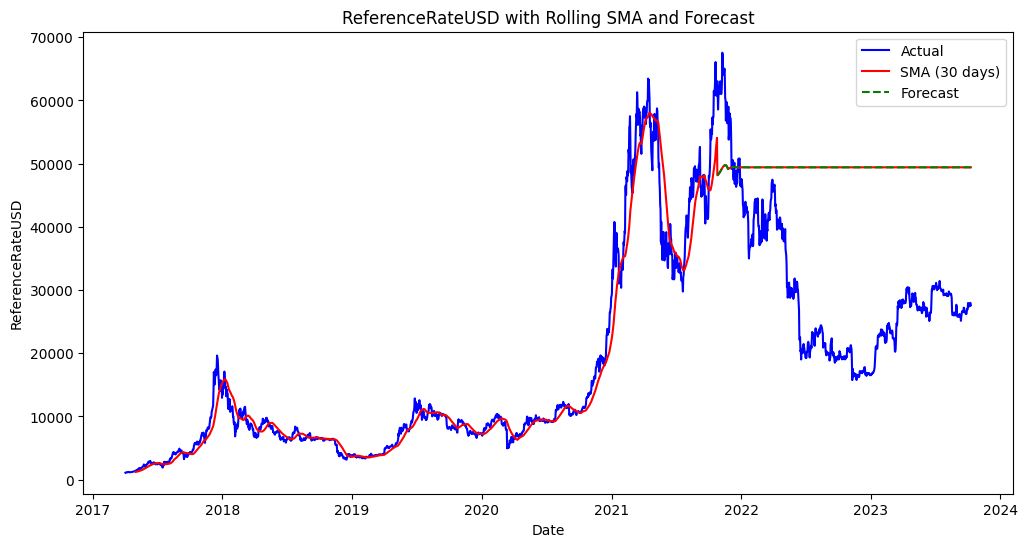

In [ ]:

#Simple Moving Average Forecast

window_size = 30  # Rolling window size for SMA

# Calculate the rolling 30-day SMA
sma = train_data['ReferenceRateUSD'].rolling(window=window_size).mean()

# Make predictions using the last observed SMA value
forecast_steps = len(test_data)
forecast_dates = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq='D')
forecast = []

for i in range(forecast_steps):
    # Calculate SMA over the last 30 days
    current_sma = sma.iloc[-window_size:].mean()

    # Make a prediction using the current SMA value
    forecast.append(current_sma)

    # Update the series to include the predicted value
    sma = pd.concat([sma, pd.Series(current_sma, index=[sma.index[-1] + pd.DateOffset(days=1)])])

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})

# Plot the actual series, the SMA, and the forecast
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index, btc_df['ReferenceRateUSD'], label='Actual', color='blue')
plt.plot(sma.index, sma, label=f'SMA ({window_size} days)', color='red')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('ReferenceRateUSD')
plt.title('ReferenceRateUSD with Rolling SMA and Forecast')
plt.legend()
plt.show()





In [ ]:
calculate_rmse(test_data['ReferenceRateUSD'],forecast_df['Forecast'])


22448.077087322406

This will be our baseline - a simple Moving average. Next we will try an ARIMA model

<Figure size 1200x600 with 0 Axes>

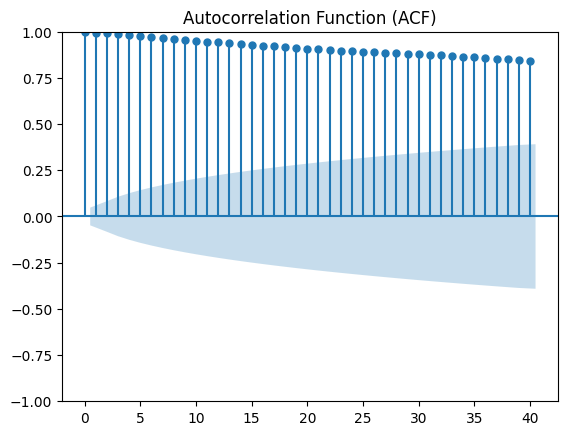

<Figure size 1200x600 with 0 Axes>

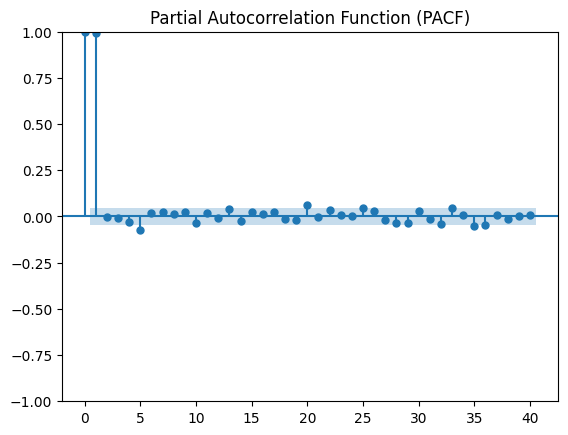

In [ ]:
plot_acf_pacf(train_data['ReferenceRateUSD'])

In [ ]:
#This is clearly non-stationary. We need to do a difference


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.0 MB/s eta 0:00:00


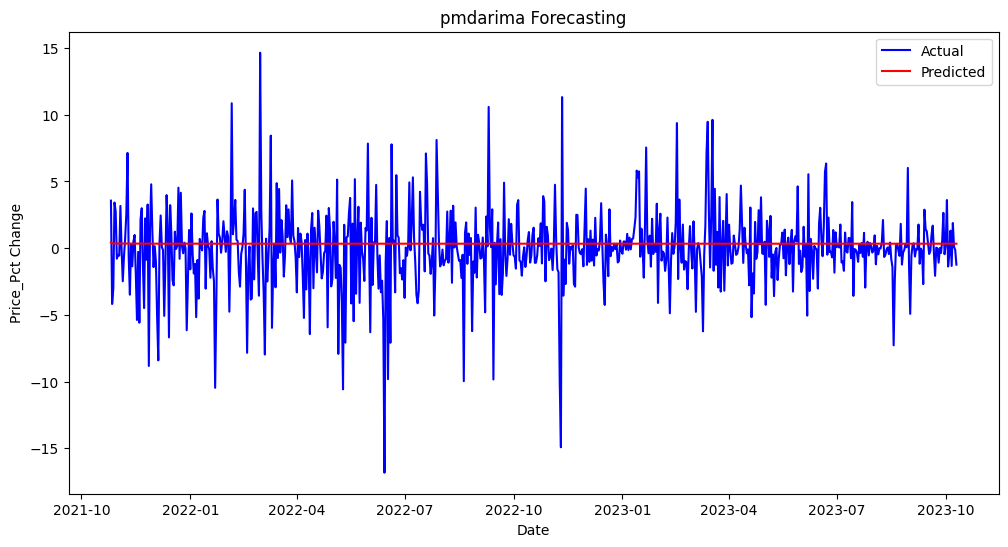

In [ ]:
from pmdarima import auto_arima

# Assuming 'btc_df' is your DataFrame with a datetime index

# Split the data into training and testing sets
train_size = 0.7
split_index = int(len(btc_df) * train_size)
train_data = btc_df.iloc[:split_index]['price_pct_change']
test_data = btc_df.iloc[split_index:]['price_pct_change']

# Use pmdarima to find the best ARIMA model
model = auto_arima(train_data, suppress_warnings=True, seasonal=False)
model_fit = model.fit(train_data)

# Make predictions on the test data
predictions = model_fit.predict(n_periods=len(test_data))

# Convert predictions and test data to a DataFrame
forecast_df = pd.DataFrame({'Date': test_data.index, 'price_pct_change': test_data.values, 'Predictions': predictions})

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['price_pct_change'], label='Actual', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Predictions'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Price_Pct Change')
plt.title('pmdarima Forecasting')
plt.legend()
plt.show()


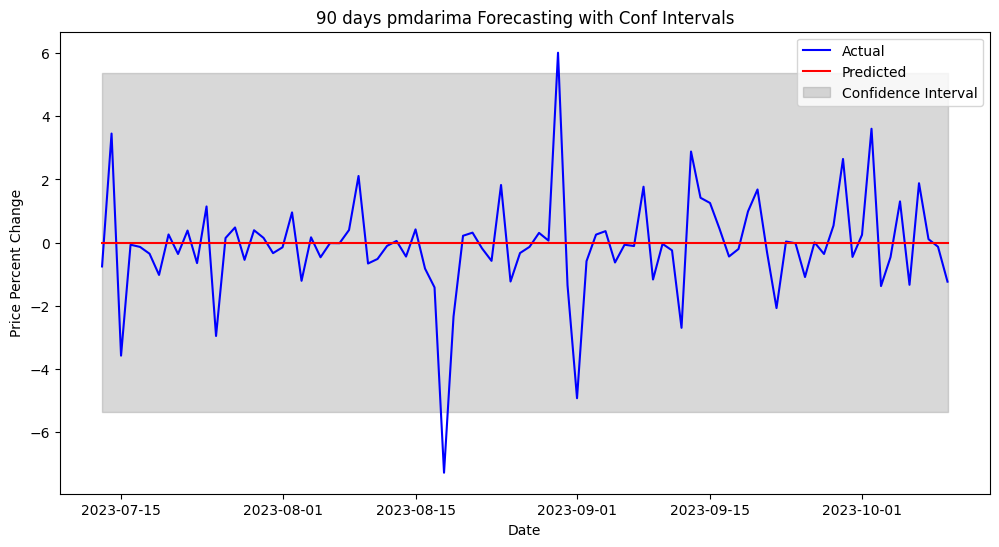

In [ ]:
#Trying a slice of the data for pmdarima. Using 365 days of training data and forecasting over past 90 days.

from pmdarima import auto_arima

# Assuming 'btc_df' is your DataFrame with a datetime index

# Set the number of days for training and testing
test_days = 90
train_days = 365

# Extract the most recent 90 days for testing
test_data = btc_df['price_pct_change'].tail(test_days)

# Extract the past 365 days (excluding the most recent 90 days) for training
train_data = btc_df['price_pct_change'][:-test_days].tail(train_days)

# Use pmdarima to find the best ARIMA model
model = auto_arima(train_data, suppress_warnings=True, seasonal=False)
model_fit = model.fit(train_data)

# Make predictions on the test data
predictions, conf_int = model_fit.predict(n_periods=len(test_data), return_conf_int=True)

# Convert predictions and test data to a DataFrame
forecast_df = pd.DataFrame({'Date': test_data.index, 'price_pct_change': test_data.values, 'Predictions': predictions})

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['price_pct_change'], label='Actual', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Predictions'], label='Predicted', color='red')
plt.fill_between(forecast_df['Date'], conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Price Percent Change')
plt.title('90 days pmdarima Forecasting with Conf Intervals')
plt.legend()
plt.show()


In [ ]:
print(forecast_df['Predictions'])

2023-07-13    0.0
2023-07-14    0.0
2023-07-15    0.0
2023-07-16    0.0
2023-07-17    0.0
             ... 
2023-10-06    0.0
2023-10-07    0.0
2023-10-08    0.0
2023-10-09    0.0
2023-10-10    0.0
Freq: D, Name: Predictions, Length: 90, dtype: float64


Try a baseline model, something simple

Rolling mean(window) model, exponential rolling mean as well

Chekc ARIMA syntax

Can Create custom features for predicting T+1

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                        SARIMAX   Log Likelihood                -884.840
Date:                Fri, 20 Oct 2023   AIC                           1771.680
Time:                        13:45:30   BIC                           1775.580
Sample:                    07-13-2022   HQIC                          1773.230
                         - 07-12-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.4675      0.290     25.763      0.000       6.899       8.036
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               427.77
Prob(Q):                              0.90   Pr

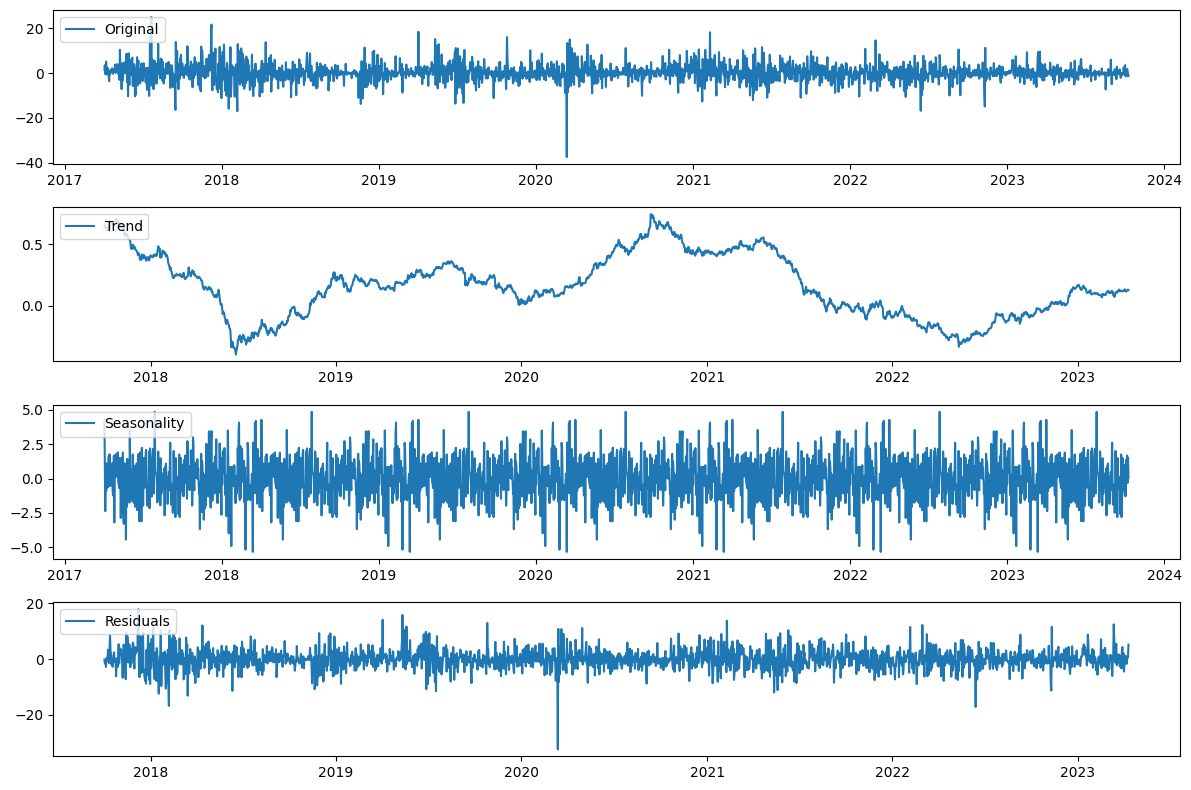

In [ ]:

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(btc_df['price_pct_change'], model='additive', period=365)

# Extract the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(btc_df['price_pct_change'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
#Let's try something new. Let's fit it into a Supervised Learning Model with 'price_pct_change' as the target feature.

target = btc_df['price_pct_change']

# Extract features from columns 30 to 59
features = btc_df.iloc[:, 30:60].columns

print(btc_df[features].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2382 entries, 2017-04-03 to 2023-10-10
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   std15                                       2382 non-null   float64
 1   std30                                       2382 non-null   float64
 2   std90                                       2382 non-null   float64
 3   AdrActCnt_smoothed_change                   2382 non-null   float64
 4   AdrBalNtv0.1Cnt_smoothed_change             2382 non-null   float64
 5   CapMVRVCur_smoothed_change                  2382 non-null   float64
 6   DiffLast_smoothed_change                    2382 non-null   float64
 7   HashRate_smoothed_change                    2382 non-null   float64
 8   FeeTotNtv_smoothed_change                   2382 non-null   float64
 9   TxCnt_smoothed_change                       2382 non-null   float64

Root Mean Squared Error (RMSE): 4.071003155759007
Mean Absolute Error (MAE): 2.6860502314798094


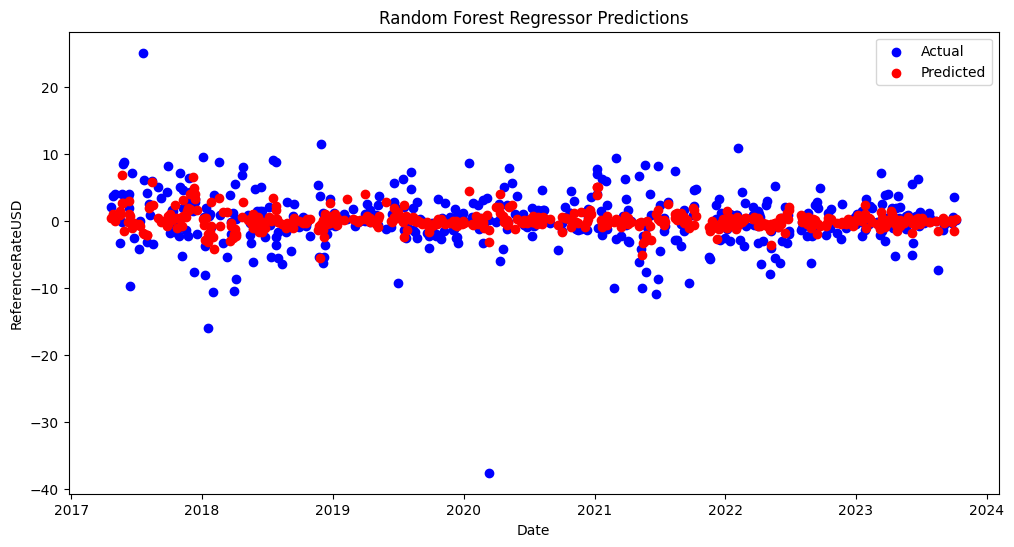

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Split the data into features (X) and target (y)
X = btc_df[features]
y = target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = rf_model.predict(X_test)

# Calculate and print the RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test.index, y_test, label='Actual', color='blue')
plt.scatter(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('ReferenceRateUSD')
plt.title('Random Forest Regressor Predictions')
plt.legend()
plt.show()


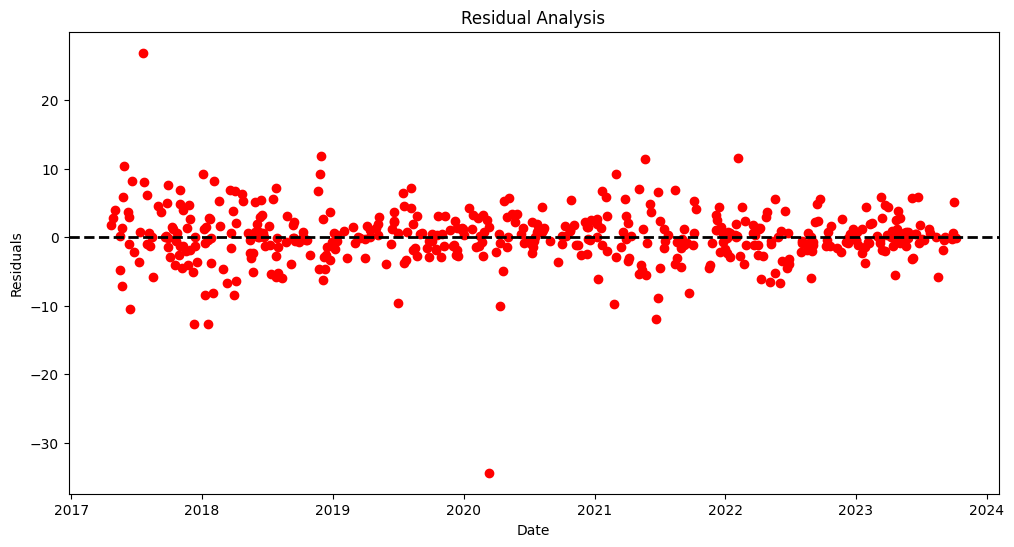

RMSE: 4.071003155759007
MAE: 2.6860502314798094
MAPE: 181.61195436278098%
Directional Accuracy: 53.03983228511531%


In [ ]:
evaluate_predictions(y_test, predictions)

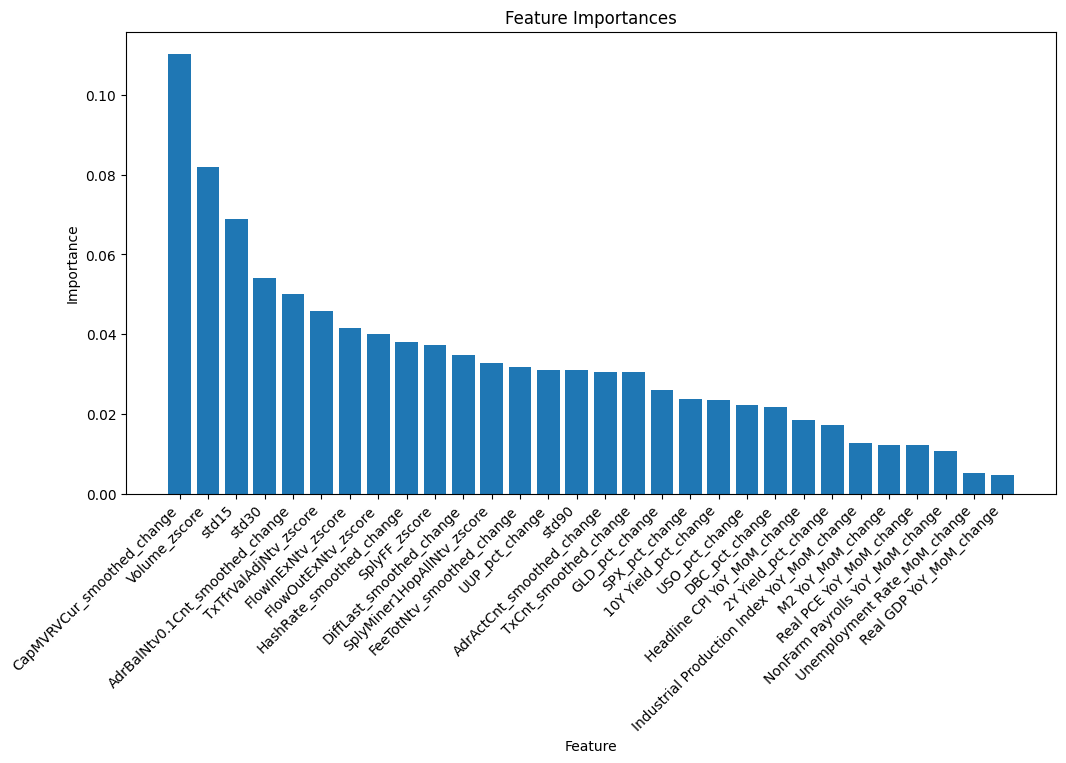

In [ ]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for easier visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45, ha='right')
plt.show()

Explanability techniques: Impact of specific features (+ / -) SHAP

On Average : What's the % difference of predicted value vs Actual Value. When does the deviation become too big? How good is this model? What % error can be considered 'good'?

Root Mean Squared Error (RMSE): 2.8454651456383284
Mean Absolute Error (MAE): 1.5743828786158263
MAPE: -10.37%


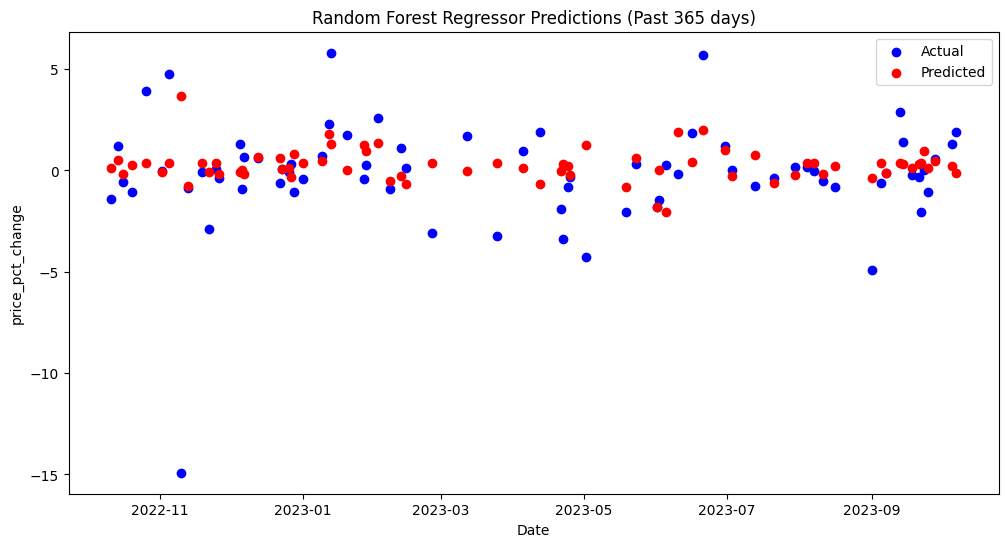

In [ ]:
#Repeat RF model for most recent 365 points

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Select the most recent 365 days of data
recent_data = btc_df.iloc[-365:]

# Split the data into features (X) and target (y)
X = recent_data[features]
y = target.iloc[-365:]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
predictions = rf_model.predict(X_test)

# Calculate and print the RMSE
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

mape = (mae / y_test.mean())
print(f'MAPE: {mape:.2f}%')


# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test.index, y_test, label='Actual', color='blue')
plt.scatter(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('price_pct_change')
plt.title('Random Forest Regressor Predictions (Past 365 days)')
plt.legend()
plt.show()


In [ ]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.6 MB/s eta 0:00:00


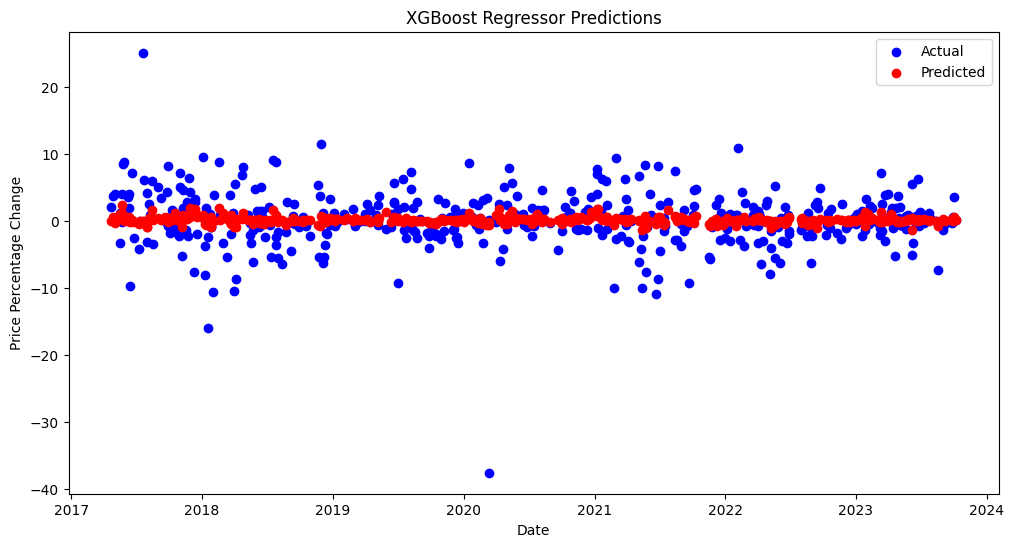

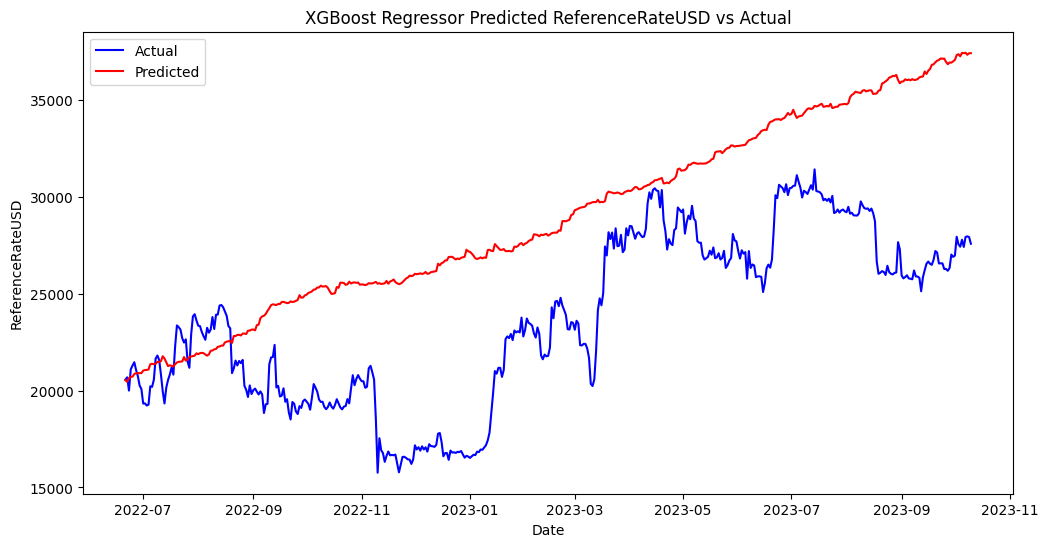

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into features (X) and target (y)
X = btc_df[features]
y = target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

# Fit the model to the training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
predictions = xg_reg.predict(X_test)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test.index, y_test, label='Actual', color='blue')
plt.scatter(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Price Percentage Change')
plt.title('XGBoost Regressor Predictions')
plt.legend()
plt.show()


# Rearrange the 'predictions' series according to the time index
predictions_series = pd.Series(predictions, index=btc_df.index[-len(y_test):])

# Get the last observed ReferenceRateUSD value before the prediction horizon
last_observed_reference_rate = btc_df['ReferenceRateUSD'].iloc[-len(predictions_series) - 1]

# Calculate cumulative percent change
cumulative_percent_change = predictions_series.cumsum()

# Convert cumulative percent change values to ReferenceRateUSD values
predicted_reference_rate = last_observed_reference_rate * (1 + cumulative_percent_change / 100)

# Align the index of predicted_reference_rate with btc_df
predicted_reference_rate = predicted_reference_rate.reindex(btc_df.index[-len(predictions_series):])

# Plot the predicted ReferenceRateUSD vs actual over the predicted time horizon
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index[-len(predictions_series):], btc_df['ReferenceRateUSD'].iloc[-len(predictions_series):], label='Actual', color='blue')
plt.plot(btc_df.index[-len(predictions_series):], predicted_reference_rate, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('ReferenceRateUSD')
plt.title('XGBoost Regressor Predicted ReferenceRateUSD vs Actual')
plt.legend()
plt.show()



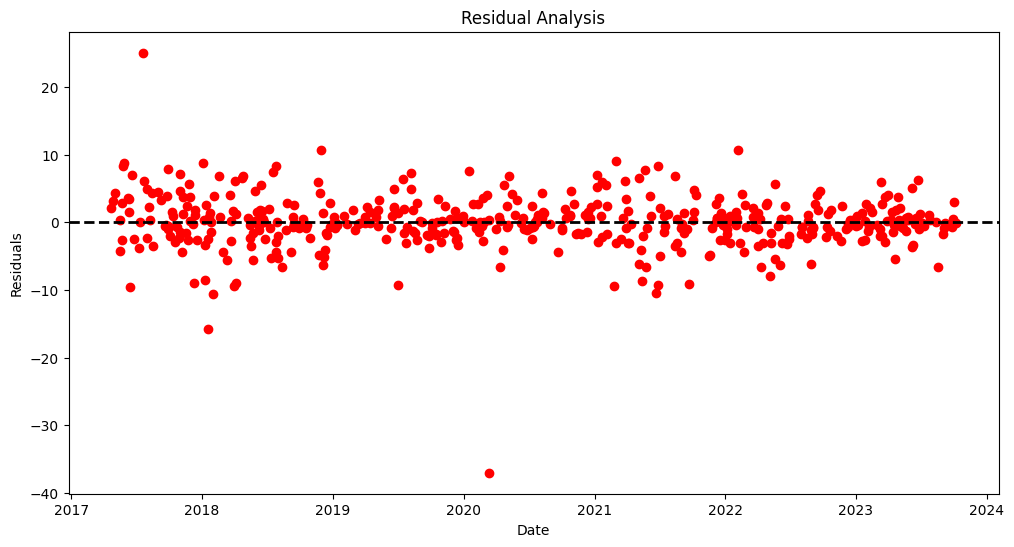

RMSE: 4.012288653899718
MAE: 2.594338290197032
MAPE: 127.73048329243043%
Directional Accuracy: 56.39412997903563%


In [ ]:
evaluate_predictions(y_test, predictions)

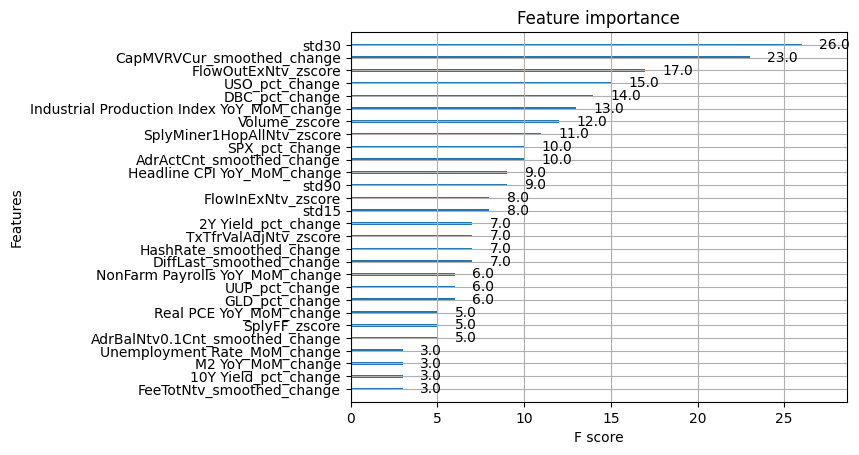

In [ ]:
# Plot feature importance
xgb.plot_importance(xg_reg)
plt.show()

# Get feature importance scores
importance = xg_reg.get_booster().get_score(importance_type='weight')

Let's see what we can explore using SHAP values.

What are SHAP Values?
SHAP (SHapley Additive exPlanations) values are a way to explain the output of any machine learning model. It uses a game theoretic approach that measures each player's contribution to the final outcome. In machine learning, each feature is assigned an importance value representing its contribution to the model's output.

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features.

[13:54:15] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


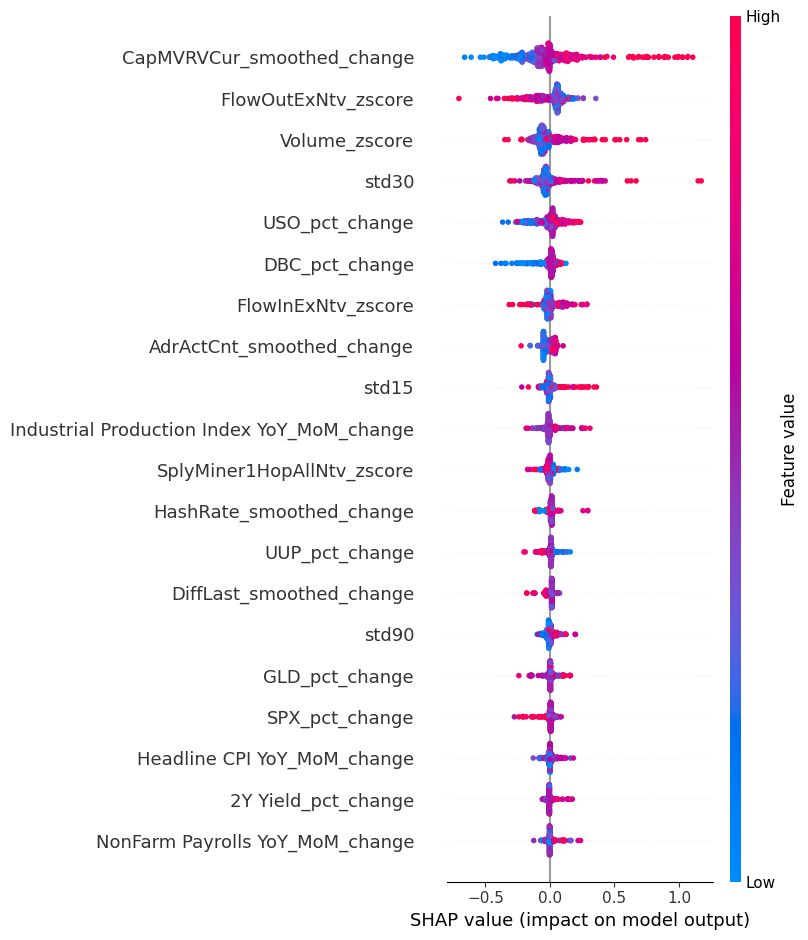

In [ ]:
import shap

explainer = shap.Explainer(xg_reg)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

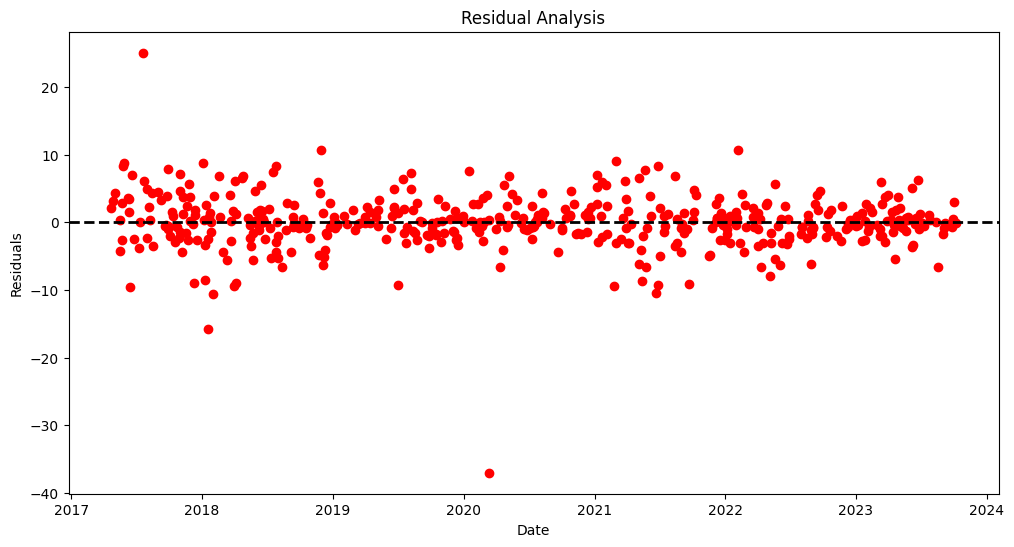

RMSE: 4.012288653899718
MAE: 2.594338290197032
MAPE: 127.73048329243043%
Directional Accuracy: 56.39412997903563%


In [ ]:
evaluate_predictions(y_test, predictions)

XGBoost actually produces the lower MAE, MAPE and directional accuracy vs Random Forest Regressor. We should check which features explain the most variance.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'objective': ['reg:squarederror'],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'alpha': [1, 5, 10],
    'n_estimators': [10, 50, 100, 200]
}
xg_reg = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_xg_reg = xgb.XGBRegressor(**best_params)
best_xg_reg.fit(X_train, y_train)
best_predictions = best_xg_reg.predict(X_test)

# Calculate and print the MSE for the best model
mse = mean_squared_error(y_test, best_predictions)
print("Mean Squared Error:", mse)

evaluate_predictions(y_test, best_predictions)



In [ ]:
# Rearrange the 'predictions' series according to the time index
best_predictions_series = pd.Series(best_predictions, index=btc_df.index[-len(y_test):])

# Get the last observed ReferenceRateUSD value before the prediction horizon
last_observed_reference_rate = btc_df['ReferenceRateUSD'].iloc[-len(best_predictions_series) - 1]

# Calculate cumulative percent change
cumulative_percent_change = best_predictions_series.cumsum()

# Convert cumulative percent change values to ReferenceRateUSD values
predicted_reference_rate = last_observed_reference_rate * (1 + cumulative_percent_change / 100)

# Align the index of predicted_reference_rate with btc_df
predicted_reference_rate = predicted_reference_rate.reindex(btc_df.index[-len(best_predictions_series):])

# Plot the predicted ReferenceRateUSD vs actual over the predicted time horizon
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index[-len(best_predictions_series):], btc_df['ReferenceRateUSD'].iloc[-len(best_predictions_series):], label='Actual', color='blue')
plt.plot(btc_df.index[-len(best_predictions_series):], predicted_reference_rate, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('ReferenceRateUSD')
plt.title('XGBoost Regressor Best Predicted ReferenceRateUSD vs Actual')
plt.legend()
plt.show()

In [ ]:
explainer = shap.Explainer(best_xg_reg)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

After hyperparameter tuning, we realize the most impactful model of XGBoost showed that 3 features (CapMVRVCur_smoothed_change, Volume_zscore and std30)!



The sequence_length parameter in the context of a recurrent neural network (RNN) refers to the number of time steps or observations from the past that the model will consider when making predictions for the next time step.

Epochs:

An epoch is one complete pass through the entire training dataset during the training of a machine learning model.
In the context of neural networks, an epoch consists of one forward pass and one backward pass (where the model's parameters are updated) for every training example in the dataset.
The number of epochs is a hyperparameter that determines how many times the learning algorithm will work through the entire training dataset.
Batch Size:

During training, instead of updating the model's parameters after each training example (which is computationally expensive), we use batches of data.
Batch size is the number of training examples utilized in one iteration. In other words, it represents the number of training samples used in each update of the model.
A batch size of 32 means that the model will see 32 examples at each update.
Batch training can provide computational advantages, and the choice of batch size is often influenced by factors such as hardware limitations and the dataset size.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error

# Create sequences for the Deep learning
sequence_length = 40
features = ['std30', 'Volume_zscore', 'CapMVRVCur_smoothed_change', 'FlowOutExNtv_zscore', 'USO_pct_change', 'Industrial Production Index YoY_MoM_change']
target = 'price_pct_change'

# Extract sequences and target
sequences = [btc_df[features].iloc[i - sequence_length:i].values for i in range(sequence_length, len(btc_df))]
target_values = btc_df[target].iloc[sequence_length:].values

# Convert the sequences and target to numpy arrays
sequences = np.array(sequences)
target_values = np.array(target_values)

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

sequences_scaled = scaler_X.fit_transform(sequences.reshape(-1, sequences.shape[-1])).reshape(sequences.shape)
target_values_scaled = scaler_y.fit_transform(target_values.reshape(-1, 1)).reshape(target_values.shape)

# Split the data into features (X) and target (y)
X = sequences_scaled
y = target_values_scaled

# Split the data into training and testing sets
split_index = int(len(sequences) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


Epoch 1/30
269/269 - 3s - loss: 0.0083 - val_loss: 0.0021 - 3s/epoch - 10ms/step
Epoch 2/30
269/269 - 2s - loss: 0.0050 - val_loss: 0.0018 - 2s/epoch - 6ms/step
Epoch 3/30
269/269 - 2s - loss: 0.0044 - val_loss: 0.0029 - 2s/epoch - 6ms/step
Epoch 4/30
269/269 - 2s - loss: 0.0040 - val_loss: 0.0018 - 2s/epoch - 7ms/step
Epoch 5/30
269/269 - 2s - loss: 0.0036 - val_loss: 0.0014 - 2s/epoch - 9ms/step
Epoch 6/30
269/269 - 2s - loss: 0.0035 - val_loss: 0.0014 - 2s/epoch - 7ms/step
Epoch 7/30
269/269 - 1s - loss: 0.0032 - val_loss: 0.0014 - 1s/epoch - 5ms/step
Epoch 8/30
269/269 - 1s - loss: 0.0032 - val_loss: 0.0013 - 1s/epoch - 6ms/step
Epoch 9/30
269/269 - 1s - loss: 0.0030 - val_loss: 0.0028 - 1s/epoch - 5ms/step
Epoch 10/30
269/269 - 2s - loss: 0.0030 - val_loss: 0.0015 - 2s/epoch - 6ms/step
Epoch 11/30
269/269 - 2s - loss: 0.0029 - val_loss: 0.0014 - 2s/epoch - 6ms/step
Epoch 12/30
269/269 - 2s - loss: 0.0028 - val_loss: 0.0015 - 2s/epoch - 6ms/step
Epoch 13/30
269/269 - 2s - loss: 0.0

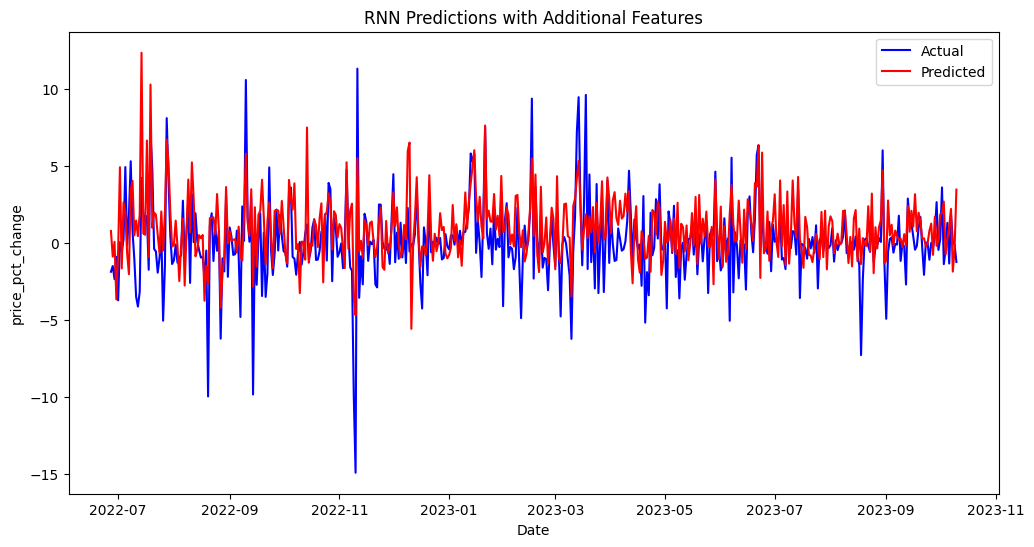

In [ ]:

# Build the RNN model
RNNmodel = Sequential()
RNNmodel.add(SimpleRNN(30, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
RNNmodel.add(Dense(1))
RNNmodel.compile(optimizer='adam', loss='mse')

# Train the model
RNNmodel.fit(X_train, y_train, epochs=30, batch_size=7, validation_data=(X_test, y_test), verbose=2)

# Make predictions on the test data
y_pred_scaled = RNNmodel.predict(X_test)

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index[-len(y_test):], y_true, label='Actual', color='blue')
plt.plot(btc_df.index[-len(y_test):], y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('price_pct_change')
plt.title('RNN Predictions with Additional Features')
plt.legend()
plt.show()


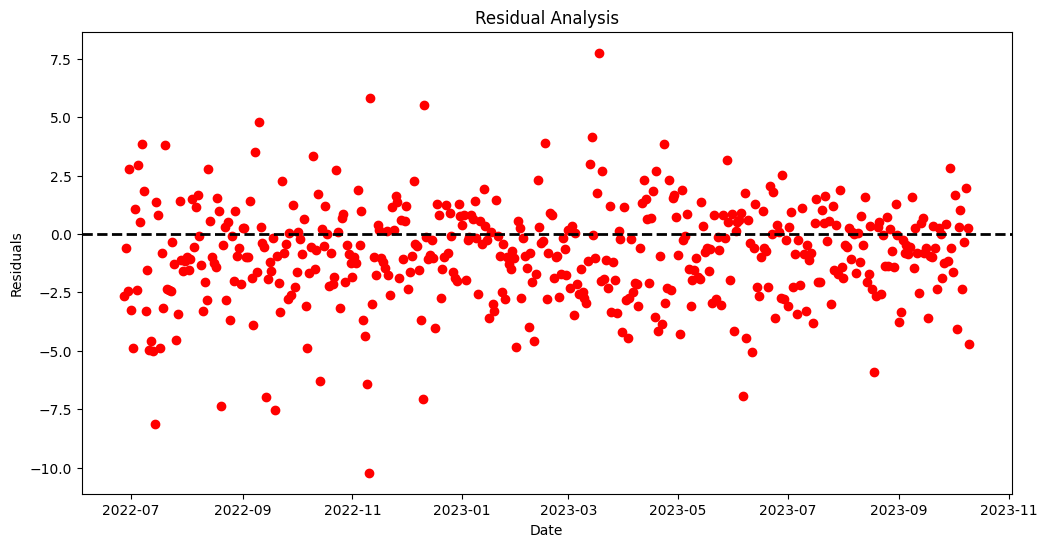

RMSE: 2.282956501001507
MAE: 1.7257888976888562
MAPE: 1418.247176471249%
Directional Accuracy: 63.05732484076433%


In [ ]:
# Inverse transform the predictions
y_pred_original = pd.Series(scaler_y.inverse_transform(y_pred_scaled).flatten(), index=btc_df.index[-len(y_test):])

y_true_original = pd.Series(scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(), index=btc_df.index[-len(y_test):])


evaluate_predictions(y_true_original, y_pred_original)


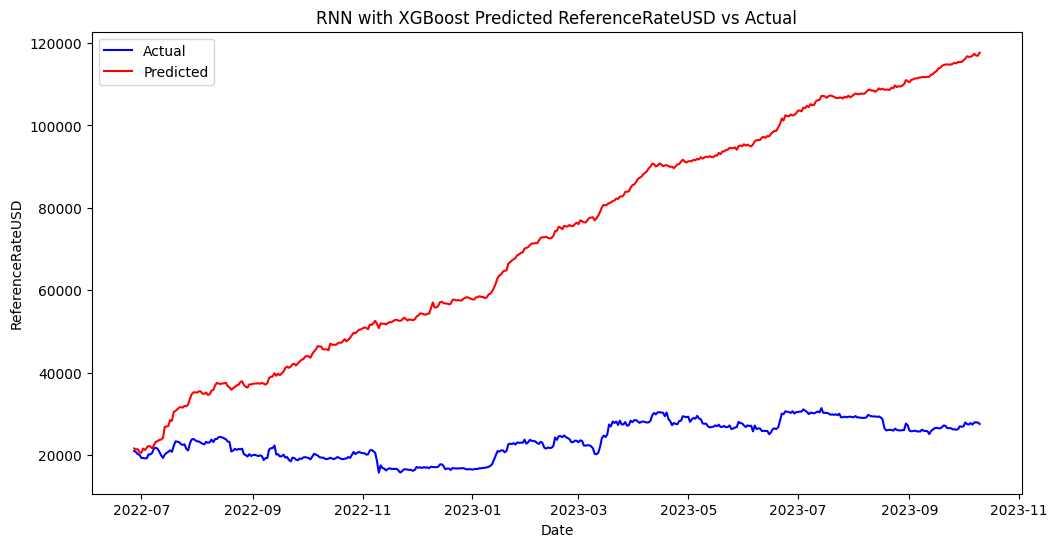

In [ ]:
# Get the last observed ReferenceRateUSD value before the prediction horizon
last_observed_reference_rate = btc_df['ReferenceRateUSD'].iloc[-len(y_pred_original) - 1]

# Calculate cumulative percent change
cumulative_percent_change = y_pred_original.cumsum()

# Convert cumulative percent change values to ReferenceRateUSD values
predicted_reference_rate = last_observed_reference_rate * (1 + cumulative_percent_change / 100)

# Align the index of predicted_reference_rate with btc_df
predicted_reference_rate = predicted_reference_rate.reindex(btc_df.index[-len(y_pred_original):])

# Plot the predicted ReferenceRateUSD vs actual over the predicted time horizon
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index[-len(y_pred_original):], btc_df['ReferenceRateUSD'].iloc[-len(y_pred_original):], label='Actual', color='blue')
plt.plot(btc_df.index[-len(y_pred_original):], predicted_reference_rate, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('ReferenceRateUSD')
plt.title('RNN with XGBoost Predicted ReferenceRateUSD vs Actual')
plt.legend()
plt.show()



Comments: Experiment with different time windows to see what actually works.

To Complete the project: Try to improve XGBoost and be aware of limitations of the models. Hyperparameter tuning of Deep learning methods.

The Above model is quite accurate with a directional accuracy of 70% correct with low MAE.

loss: 0.0265: The training loss at the end of this epoch. The loss is a measure of how well the model is performing, and the goal is usually to minimize this value.

val_loss: 0.0027: The validation loss at the end of this epoch. This is the loss calculated on a separate validation dataset that the model has not seen during training. It gives an indication of how well the model is generalizing to new, unseen data. These outputs are useful for monitoring the training process. The decreasing training loss is a good sign, but it's important to check the validation loss to ensure the model is not overfitting (performing well on training data but poorly on new data). If the validation loss is consistently much higher than the training loss, it might indicate overfitting. Adjustments to the model architecture, regularization, or the dataset may be needed in such cases.



We may need to tune the hyperparameters of this simple RNN.

We can try an LTSM model now.

Epoch 1/30
268/268 - 6s - loss: 0.0267 - val_loss: 0.0024 - 6s/epoch - 21ms/step
Epoch 2/30
268/268 - 4s - loss: 0.0051 - val_loss: 0.0019 - 4s/epoch - 13ms/step
Epoch 3/30
268/268 - 5s - loss: 0.0048 - val_loss: 0.0033 - 5s/epoch - 17ms/step
Epoch 4/30
268/268 - 4s - loss: 0.0048 - val_loss: 0.0018 - 4s/epoch - 16ms/step
Epoch 5/30
268/268 - 4s - loss: 0.0046 - val_loss: 0.0025 - 4s/epoch - 14ms/step
Epoch 6/30
268/268 - 4s - loss: 0.0046 - val_loss: 0.0016 - 4s/epoch - 13ms/step
Epoch 7/30
268/268 - 5s - loss: 0.0045 - val_loss: 0.0039 - 5s/epoch - 19ms/step
Epoch 8/30
268/268 - 3s - loss: 0.0046 - val_loss: 0.0016 - 3s/epoch - 13ms/step
Epoch 9/30
268/268 - 4s - loss: 0.0045 - val_loss: 0.0030 - 4s/epoch - 13ms/step
Epoch 10/30
268/268 - 4s - loss: 0.0044 - val_loss: 0.0018 - 4s/epoch - 16ms/step
Epoch 11/30
268/268 - 5s - loss: 0.0043 - val_loss: 0.0024 - 5s/epoch - 17ms/step
Epoch 12/30
268/268 - 4s - loss: 0.0042 - val_loss: 0.0020 - 4s/epoch - 13ms/step
Epoch 13/30
268/268 - 4s 

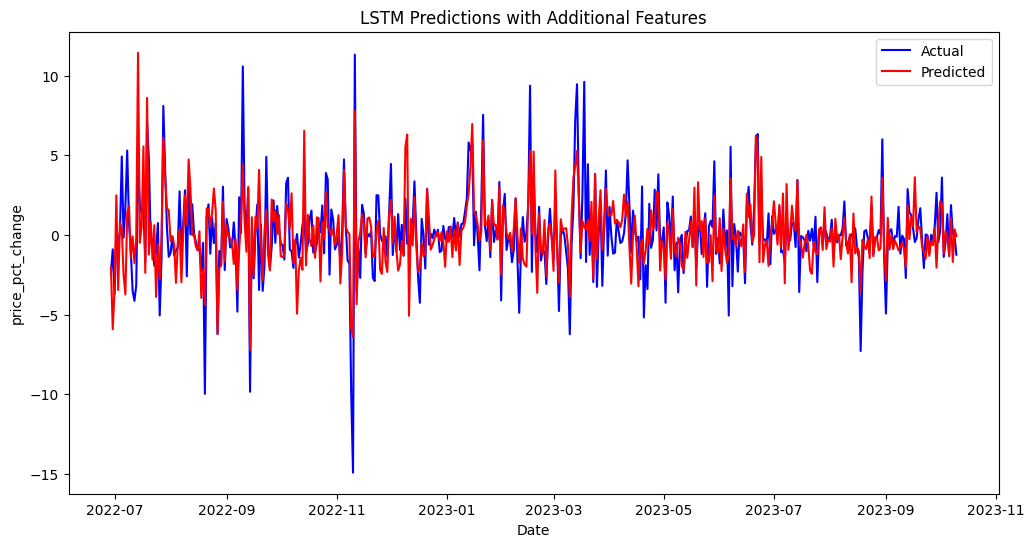

In [ ]:
from tensorflow.keras.layers import LSTM

# Build the LSTM Model
LSTM_model = Sequential()
LSTM_model.add(LSTM(30, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam', loss='mse')

# Train the model
LSTM_model.fit(X_train, y_train, epochs=30, batch_size=7, validation_data=(X_test, y_test), verbose=2)

# Make predictions on the test data
y_pred_scaled = LSTM_model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index[-len(y_test):], y_true, label='Actual', color='blue')
plt.plot(btc_df.index[-len(y_test):], y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('price_pct_change')
plt.title('LSTM Predictions with Additional Features')
plt.legend()
plt.show()


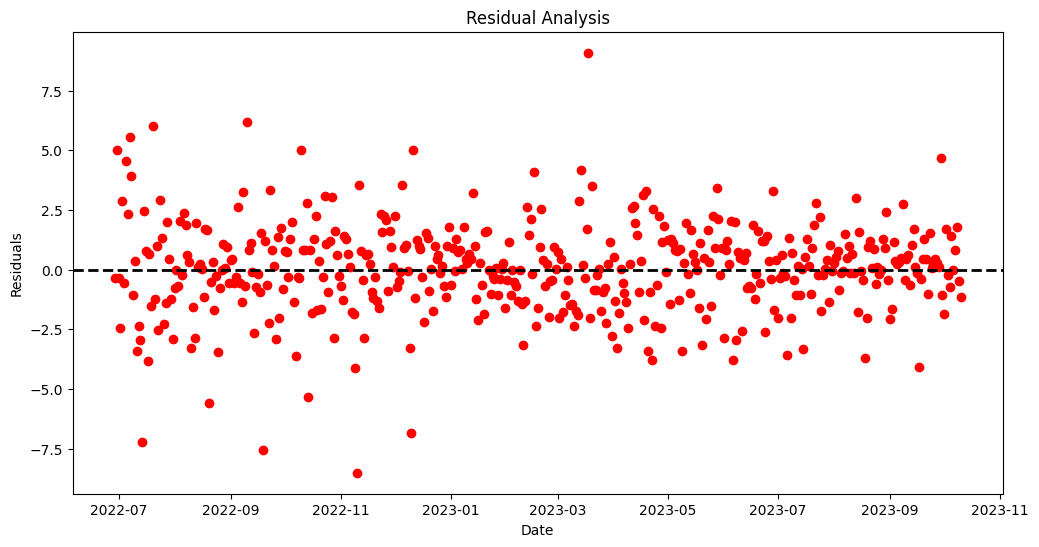

RMSE: 1.9241533507242965
MAE: 1.4003633892795562
MAPE: 929.500761124015%
Directional Accuracy: 69.7228144989339%


In [ ]:
# Assuming 'btc_df' is your DataFrame with a datetime index
original_index = btc_df.index

# Reindex y_pred to match the original index
y_pred = pd.Series(y_pred.squeeze(), index=original_index[-len(y_pred):])

# Reindex y_true to match the original index
y_true = pd.Series(scaler_y.inverse_transform(y_test.reshape(-1, 1)).squeeze(), index=original_index[-len(y_test):])

# Now you can use y_true and y_pred with your evaluate_predictions function
evaluate_predictions(y_true, y_pred)


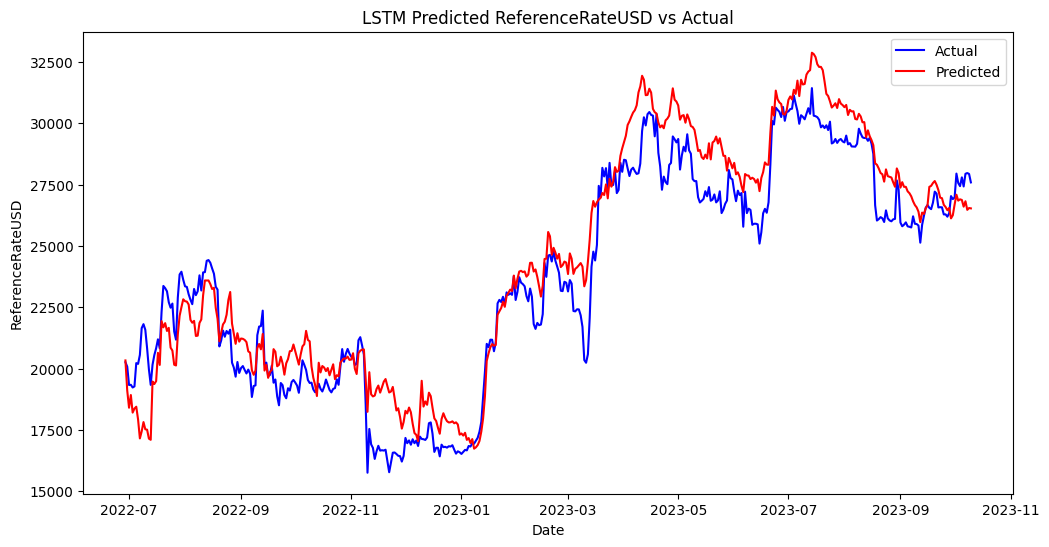

In [ ]:
# Get the last observed ReferenceRateUSD value before the prediction horizon
last_observed_reference_rate = btc_df['ReferenceRateUSD'].iloc[-len(y_pred) - 1]

# Calculate cumulative percent change
cumulative_percent_change = y_pred.cumsum()

# Convert cumulative percent change values to ReferenceRateUSD values
predicted_reference_rate = last_observed_reference_rate * (1 + cumulative_percent_change / 100)

# Align the index of predicted_reference_rate with btc_df
predicted_reference_rate = predicted_reference_rate.reindex(btc_df.index[-len(y_pred):])

# Plot the predicted ReferenceRateUSD vs actual over the predicted time horizon
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index[-len(y_pred):], btc_df['ReferenceRateUSD'].iloc[-len(y_pred):], label='Actual', color='blue')
plt.plot(btc_df.index[-len(y_pred):], predicted_reference_rate, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('ReferenceRateUSD')
plt.title('LSTM Predicted ReferenceRateUSD vs Actual')
plt.legend()
plt.show()


In [ ]:
from shutil import copyfile

#Saving this as the best model
LSTM_model.save('best_lstm_model.keras')

# Specify the source and destination paths (change as needed)
source_path = 'best_lstm_model.keras'
destination_path = '/content/drive/My Drive//Colab Notebooks/Coinmetrics Data/best_lstm_model.keras'

# Copy the model file to your Google Drive
copyfile(source_path, destination_path)

#from tensorflow.keras.models import load_model

#loaded_model = load_model('best_lstm_model.keras')



'/content/drive/My Drive//Colab Notebooks/Coinmetrics Data/best_lstm_model.keras'

In [ ]:
#Adding additional LSTM layer, drop out layer and early stopping mechanism

Epoch 1/30
269/269 - 12s - loss: 0.0186 - val_loss: 0.0017 - 12s/epoch - 43ms/step
Epoch 2/30
269/269 - 7s - loss: 0.0052 - val_loss: 0.0021 - 7s/epoch - 27ms/step
Epoch 3/30
269/269 - 7s - loss: 0.0048 - val_loss: 0.0017 - 7s/epoch - 26ms/step
Epoch 4/30
269/269 - 7s - loss: 0.0051 - val_loss: 0.0020 - 7s/epoch - 27ms/step
Epoch 5/30
269/269 - 7s - loss: 0.0050 - val_loss: 0.0019 - 7s/epoch - 25ms/step
Epoch 6/30
269/269 - 7s - loss: 0.0048 - val_loss: 0.0017 - 7s/epoch - 26ms/step
Epoch 7/30
269/269 - 7s - loss: 0.0049 - val_loss: 0.0023 - 7s/epoch - 26ms/step
Epoch 8/30
269/269 - 7s - loss: 0.0048 - val_loss: 0.0017 - 7s/epoch - 26ms/step
Epoch 9/30
269/269 - 7s - loss: 0.0048 - val_loss: 0.0017 - 7s/epoch - 27ms/step
Epoch 10/30
269/269 - 8s - loss: 0.0048 - val_loss: 0.0018 - 8s/epoch - 29ms/step
Epoch 11/30
269/269 - 7s - loss: 0.0047 - val_loss: 0.0017 - 7s/epoch - 26ms/step
Epoch 12/30
269/269 - 8s - loss: 0.0047 - val_loss: 0.0021 - 8s/epoch - 29ms/step
Epoch 13/30
269/269 - 7

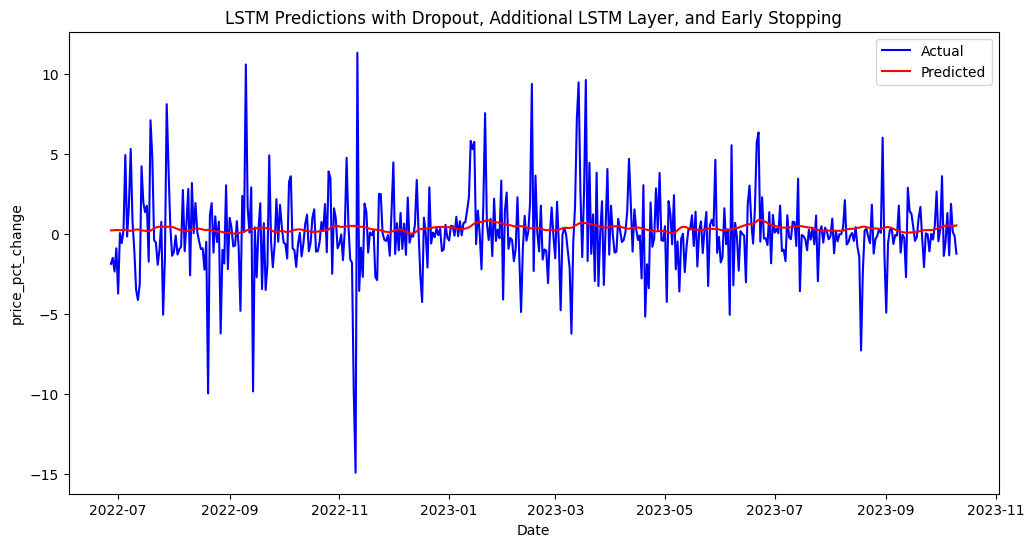

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Build the RNN model with one LSTM layer, dropout layers, and another LSTM layer
LSTM_model = Sequential()
LSTM_model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
LSTM_model.add(Dropout(0.2))  # Add a dropout layer to reduce overfitting
LSTM_model.add(LSTM(50, activation='relu', return_sequences=False))  # Add another LSTM layer
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam', loss='mse')

# Train the model with early stopping
LSTM_model.fit(X_train, y_train, epochs=30, batch_size=7, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping])

# Make predictions on the test data
y_pred_scaled = LSTM_model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index[-len(y_test):], y_true, label='Actual', color='blue')
plt.plot(btc_df.index[-len(y_test):], y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('price_pct_change')
plt.title('LSTM Predictions with Dropout, Additional LSTM Layer, and Early Stopping')
plt.legend()
plt.show()




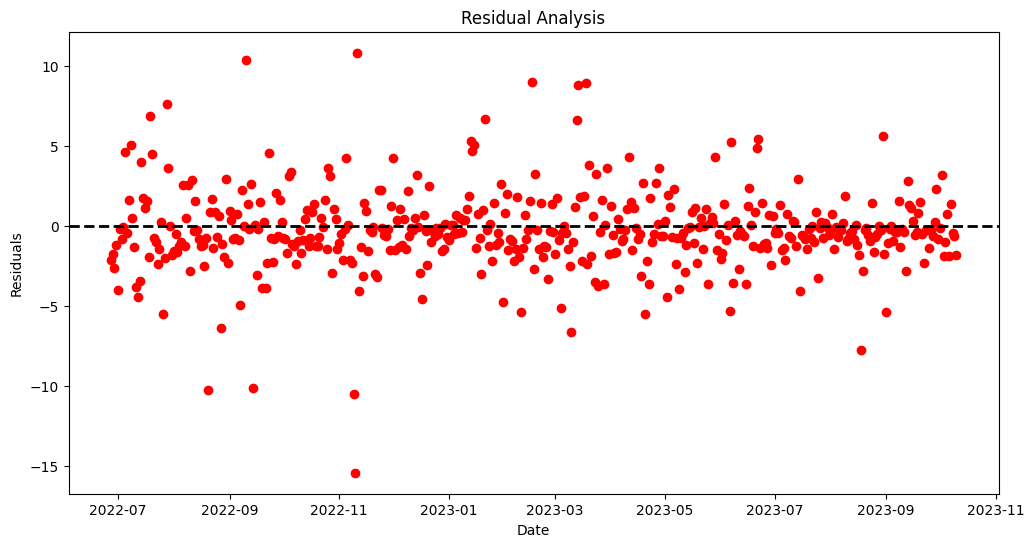

RMSE: 2.5590940892870346
MAE: 1.7140922997629073
MAPE: 529.0043199658106%
Directional Accuracy: 46.92144373673036%


In [ ]:
# Assuming 'btc_df' is your DataFrame with a datetime index
original_index = btc_df.index

# Reindex y_pred to match the original index
y_pred = pd.Series(y_pred.squeeze(), index=original_index[-len(y_pred):])

# Reindex y_true to match the original index
y_true = pd.Series(scaler_y.inverse_transform(y_test.reshape(-1, 1)).squeeze(), index=original_index[-len(y_test):])

# Now you can use y_true and y_pred with your evaluate_predictions function
evaluate_predictions(y_true, y_pred)

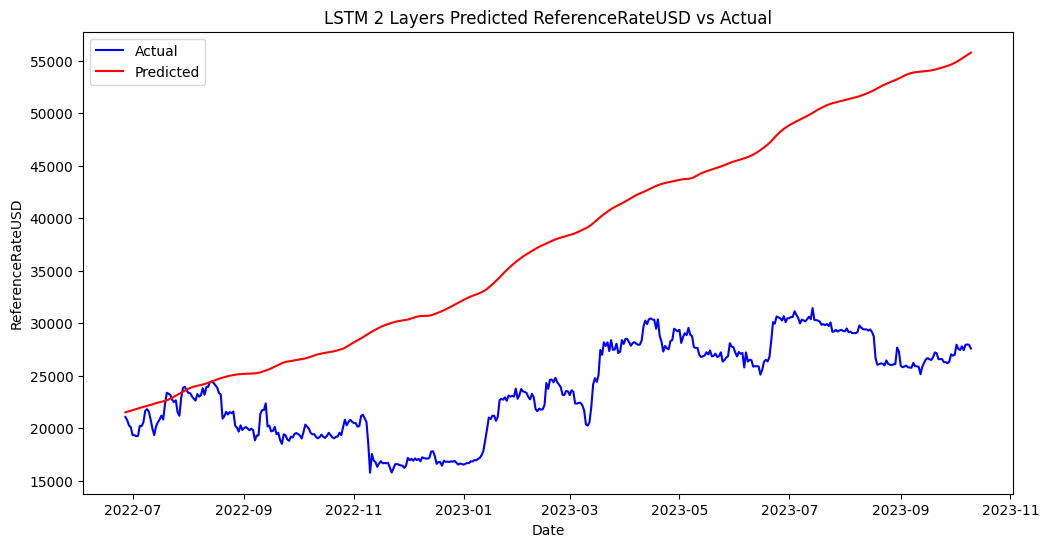

In [ ]:
# Get the last observed ReferenceRateUSD value before the prediction horizon
last_observed_reference_rate = btc_df['ReferenceRateUSD'].iloc[-len(y_pred) - 1]

# Calculate cumulative percent change
cumulative_percent_change = y_pred.cumsum()

# Convert cumulative percent change values to ReferenceRateUSD values
predicted_reference_rate = last_observed_reference_rate * (1 + cumulative_percent_change / 100)

# Align the index of predicted_reference_rate with btc_df
predicted_reference_rate = predicted_reference_rate.reindex(btc_df.index[-len(y_pred):])

# Plot the predicted ReferenceRateUSD vs actual over the predicted time horizon
plt.figure(figsize=(12, 6))
plt.plot(btc_df.index[-len(y_pred):], btc_df['ReferenceRateUSD'].iloc[-len(y_pred):], label='Actual', color='blue')
plt.plot(btc_df.index[-len(y_pred):], predicted_reference_rate, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('ReferenceRateUSD')
plt.title('LSTM 2 Layers Predicted ReferenceRateUSD vs Actual')
plt.legend()
plt.show()

2 Layer LSTM actually does worse than 1 layer. Looks like there was too much smoothing in the predictions.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def find_best_sequence_length_with_lstm(data, features, target, candidate_lengths):
    results = {}

    for sequence_length in candidate_lengths:
        # Extract sequences for the current sequence length
        sequences = [data[features].iloc[i - sequence_length:i].values for i in range(sequence_length, len(data))]
        target_values = data[target].iloc[sequence_length:].values

        # Convert the sequences and target to numpy arrays
        sequences = np.array(sequences)
        target_values = np.array(target_values)

        # Normalize the data
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        sequences_scaled = scaler_X.fit_transform(sequences.reshape(-1, sequences.shape[-1])).reshape(sequences.shape)
        target_values_scaled = scaler_y.fit_transform(target_values.reshape(-1, 1)).reshape(target_values.shape)

        # Split the data into training and testing sets
        split_index = int(len(sequences) * 0.8)
        X_train, X_test = sequences_scaled[:split_index], sequences_scaled[split_index:]
        y_train, y_test = target_values_scaled[:split_index], target_values_scaled[split_index:]

        # Create and train the LSTM model
        model = Sequential()
        model.add(LSTM(30, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mae')

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=100, batch_size=7, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping])

        # Evaluate the model
        y_pred_scaled = model.predict(X_test)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

        mae = mean_absolute_error(y_true, y_pred)

        results[sequence_length] = mae

    best_sequence_length = min(results, key=results.get)
    return best_sequence_length, results

# Usage example
candidate_lengths = [10, 20, 30, 40, 50]
best_length, mae_results = find_best_sequence_length_with_lstm(btc_df, features, target, candidate_lengths)
print(f"The best sequence length is {best_length} with MAE {mae_results[best_length]}")



Epoch 1/100
271/271 - 3s - loss: 0.0810 - val_loss: 0.0313 - 3s/epoch - 10ms/step
Epoch 2/100
271/271 - 2s - loss: 0.0519 - val_loss: 0.0343 - 2s/epoch - 7ms/step
Epoch 3/100
271/271 - 2s - loss: 0.0483 - val_loss: 0.0397 - 2s/epoch - 6ms/step
Epoch 4/100
271/271 - 1s - loss: 0.0475 - val_loss: 0.0293 - 1s/epoch - 4ms/step
Epoch 5/100
271/271 - 1s - loss: 0.0478 - val_loss: 0.0281 - 1s/epoch - 4ms/step
Epoch 6/100
271/271 - 1s - loss: 0.0468 - val_loss: 0.0273 - 1s/epoch - 4ms/step
Epoch 7/100
271/271 - 1s - loss: 0.0462 - val_loss: 0.0303 - 1s/epoch - 4ms/step
Epoch 8/100
271/271 - 1s - loss: 0.0465 - val_loss: 0.0272 - 1s/epoch - 4ms/step
Epoch 9/100
271/271 - 1s - loss: 0.0467 - val_loss: 0.0268 - 1s/epoch - 4ms/step
Epoch 10/100
271/271 - 1s - loss: 0.0467 - val_loss: 0.0275 - 1s/epoch - 4ms/step
Epoch 11/100
271/271 - 1s - loss: 0.0467 - val_loss: 0.0266 - 1s/epoch - 4ms/step
Epoch 12/100
271/271 - 1s - loss: 0.0454 - val_loss: 0.0269 - 1s/epoch - 4ms/step
Epoch 13/100
271/271 - 2

In Conclusion - the LTSM model with sequence = 40 and features being the top 6 of XGBoost is produces the best predictions for ReferenceRateUSD of Bitcoin!

